In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [41]:
df = pd.read_csv('ai_ml_cybersecurity_dataset.csv')

In [42]:
#Preprocessing; 
# - Encode kolom kategorikal  ke numerik
# - Encode kolom target (Attack Type)
# - Encode kolom kategorikal lainnya
label_encoder = LabelEncoder()
df['Attack Type'] = label_encoder.fit_transform(df['Attack Type'])

categorical_columns = ['User Agent', 'Threat Intelligence', 'Attack Severity']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [43]:
#Memisahkan fitur (X) dan target (Y)
X = df.drop(columns=['Event ID', 'Timestamp', 'Source IP', 'Destination IP', 'Response Action', 'Attack Type'])
y = df['Attack Type']

In [44]:
#Bagi Data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [45]:
#Implement Naive Bayes Classifier (NBC)
nb_model = GaussianNB()


In [46]:
#Latih Model
nb_model.fit(X_train, y_train)


GaussianNB()

In [47]:
#Prediksi
y_pred_nb = nb_model.predict(X_test)


In [48]:
#Evaluasi model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classifier Accuracy:", accuracy_nb)
print("Classification Report for Naive Bayes:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Classifier Accuracy: 0.20416666666666666
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.19      0.17      0.18      1165
           1       0.21      0.12      0.16      1210
           2       0.23      0.13      0.17      1234
           3       0.20      0.38      0.26      1212
           4       0.20      0.22      0.21      1179

    accuracy                           0.20      6000
   macro avg       0.21      0.20      0.20      6000
weighted avg       0.21      0.20      0.20      6000



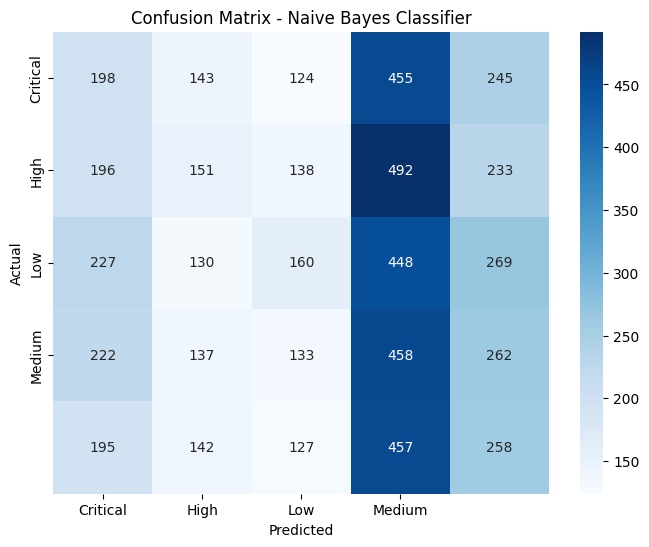

In [49]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
#Implement Certainty Factor (CF); Menghitung Certainty Factor
def certainty_factor(rule_confidence, evidence_confidence):
    if rule_confidence * evidence_confidence > 0:
        return (rule_confidence * evidence_confidence) / (1 - min(rule_confidence, evidence_confidence))
    elif rule_confidence * evidence_confidence < 0:
        return (rule_confidence + evidence_confidence) / (1 - min(abs(rule_confidence), abs(evidence_confidence)))
    else:
        return 0


In [51]:
#Aturan 
rules = {
    'Ransomware': {'User Agent': 1, 'Threat Intelligence': 2, 'Attack Severity': 3},  
    'Malware': {'User Agent': 2, 'Threat Intelligence': 1, 'Attack Severity': 2},     
    'Phishing': {'User Agent': 3, 'Threat Intelligence': 0, 'Attack Severity': 1},     
    'DDoS Attack': {'User Agent': 4, 'Threat Intelligence': 2, 'Attack Severity': 3},  
    'SQL Injection': {'User Agent': 5, 'Threat Intelligence': 1, 'Attack Severity': 2}  
}

In [52]:
#Menghitung CF untuk setiap aturan
cf_results = []
for index, row in X_test.iterrows():
    cf_values = {}
    for attack_type, conditions in rules.items():
        cf = 1.0
        for feature, value in conditions.items():
            if row[feature] == value:
                cf *= 0.8  
            else:
                cf *= 0.2  
        cf_values[attack_type] = cf
    cf_results.append(max(cf_values, key=cf_values.get))

In [ ]:
# Pastikan label_encoder memiliki mapping untuk semua label yang mungkin dihasilkan oleh CF
# Konversi hasil CF ke numerik

all_possible_labels = np.unique(list(rules.keys()) + list(label_encoder.classes_))
label_encoder.fit(all_possible_labels)
cf_results_numeric = label_encoder.transform(cf_results)

In [55]:
# Evaluasi model Certainty Factor
accuracy_cf = accuracy_score(y_test, cf_results_numeric)
print("Certainty Factor Accuracy:", accuracy_cf)
print("Classification Report for Certainty Factor:\n", classification_report(y_test, cf_results_numeric))

Certainty Factor Accuracy: 0.051833333333333335
Classification Report for Certainty Factor:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1165
           1       0.00      0.00      0.00      1210
           2       0.00      0.00      0.00      1234
           3       0.20      0.26      0.23      1212
           4       0.00      0.00      0.00      1179
           5       0.00      0.00      0.00         0

    accuracy                           0.05      6000
   macro avg       0.03      0.04      0.04      6000
weighted avg       0.04      0.05      0.05      6000



/home/gu5p3r0x/Downloads/Alhamdulillah-KerjaTugas/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gu5p3r0x/Downloads/Alhamdulillah-KerjaTugas/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gu5p3r0x/Downloads/Alhamdulillah-KerjaTugas/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

In [ ]:
# Plot Confusion Matrix
cm_cf = confusion_matrix(y_test, cf_results_numeric)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cf, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Certainty Factor')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_28380/2848723442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette='viridis')


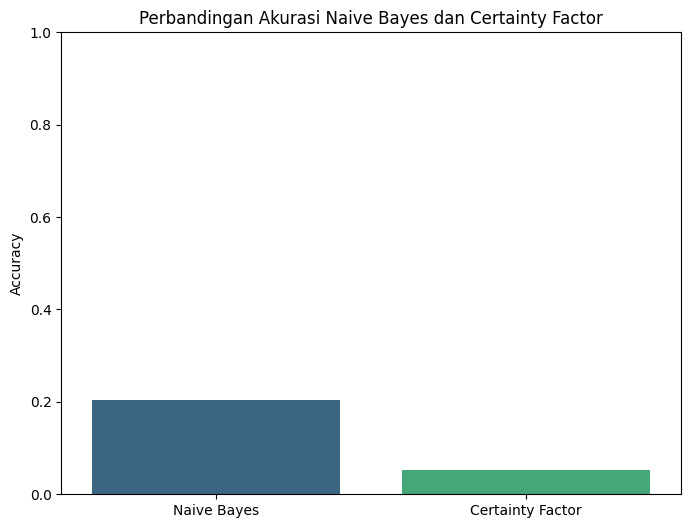


Perbandingan Akurasi:
- Naive Bayes Classifier: 0.20
- Certainty Factor: 0.05
Naive Bayes Classifier lebih akurat daripada Certainty Factor.


In [57]:
methods = ['Naive Bayes', 'Certainty Factor']
accuracies = [accuracy_nb, accuracy_cf]

plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=accuracies, palette='viridis')
plt.title('Perbandingan Akurasi Naive Bayes dan Certainty Factor')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.show()

print("\nPerbandingan Akurasi:")
print(f"- Naive Bayes Classifier: {accuracy_nb:.2f}")
print(f"- Certainty Factor: {accuracy_cf:.2f}")

if accuracy_nb > accuracy_cf:
    print("Naive Bayes Classifier lebih akurat daripada Certainty Factor.")
else:
    print("Certainty Factor lebih akurat daripada Naive Bayes Classifier.")